In [187]:
import random
import json

import lang2vec.lang2vec as l2v

from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F


class LanguageMLP(nn.Module):
    def __init__(self, config, in_language_list: List[str], oov_language_list: List[str], letter_codes: str):
        super(LanguageMLP, self).__init__()

        self.config = config
        self.do_onehot = config.one_hot
        self.in_language_list = in_language_list
        self.oov_language_list = oov_language_list
        self.letter_codes = letter_codes

        l2v.LETTER_CODES_FILE = letter_codes
        l2v.LETTER_CODES = json.load(open(letter_codes))

        self.l2v_cache_avg = dict()
        self.l2v_cache_missing = dict()
        self._cache_language_features()

        nl_project = config.nl_project
        in_features = len(self.in_language_list) + 1 + config.num_language_features if self.do_onehot else config.num_language_features

        # number of geo feats = 299
        self.num_geo_feats = 299 if 'geo' in self.config.language_features else 0

        self.nonlinear_project = nn.Linear(in_features, nl_project)
        self.down_project = nn.Linear(nl_project, config.low_rank_dim)
        self.activation = F.relu
        self.dropout = nn.Dropout(config.language_emb_dropout)

        self.up_project = nn.Linear(config.low_rank_dim, in_features)
        self.loss_fct = nn.BCEWithLogitsLoss(reduction='mean')

        self.update_embs = True
        self.lang_emb = None
        self.loss = None
        self.accuracy = None
        self.evaluate_typo = True

    def forward(self, lang_ids, perm_idx=None, fold_k=0):

        lang_vector, missing_feats = self._encode_language_ids(lang_ids)

        if self.training or self.evaluate_typo:
            unmasked_lang_vector = torch.tensor(lang_vector).to(lang_ids.device)

        # mask typological feature vector
        mask, masked_indexes = torch.ones(len(lang_vector)), None
        if self.config.typo_mask:
            mask, masked_indexes = self._mask_features(missing_feats[:len(lang_vector)-self.num_geo_feats], self.config.typo_mask_ratio, 
                                                       perm_idx=perm_idx, k=fold_k)
            mask = torch.cat((mask, torch.zeros(self.num_geo_feats).byte()))

        # replace 0's with -1's
        lang_vector = [-1.0 if (f == 0.0 or f == '--') else f for f in lang_vector]
        lang_vector = torch.tensor(lang_vector).to(lang_ids.device)
        lang_vector = (~mask).float().to(lang_ids.device) * lang_vector

        lang_emb = self.nonlinear_project(lang_vector)
        lang_emb = self.activation(lang_emb)
        lang_emb = self.down_project(lang_emb)
        lang_emb = self.dropout(lang_emb)

        loss, binary_acc = 0, 0
        if self.config.typo_mask and (self.training or self.evaluate_typo):
            loss, probs = self._decode_feats(lang_emb, masked_indexes, unmasked_lang_vector)
            binary_acc = self._calculate_accuracy(unmasked_lang_vector[masked_indexes], probs[masked_indexes])
            #print(masked_indexes)
            
        return lang_emb, (loss, binary_acc)

    def _decode_feats(self, lang_emb, masked_indexes, lang_vector):
        hidden = self.activation(self.up_project(lang_emb))

        # TODO: check if this is problematics
        loss = self.loss_fct(hidden[masked_indexes], lang_vector[masked_indexes])
        loss = loss * self.config.typo_loss_weight

        probs = F.sigmoid(hidden)

        return loss, probs

    def _calculate_accuracy(self, y_true, y_prob):
        assert len(y_true.shape) == 1 and y_true.shape == y_prob.shape
        y_prob = y_prob > 0.5
        return (y_true == y_prob.float()).sum().item() / y_true.shape[0]

    def get_language_emb(self, lang_ids, update=False):

        if self.update_embs:
            self.lang_emb, (self.loss, self.accuracy) = self.forward(lang_ids)
            self.update_embs = False

        if update:
            self.update_embs = True

        return self.lang_emb, (self.loss, self.accuracy)

    def get_accuracy(self):
        main_metrics = {
            f".run/typo/acc": self.accuracy
        }
        return {**main_metrics}

    def _encode_language_ids(self, language_id: int) -> List[int]:

        # language one-hot vector
        # 0th id for UNK language
        # drop language_id
        one_hot = [0 for i in range(len(self.in_language_list) + 1)]
        if (random.random() < self.config.language_drop_rate) and self.training:
            one_hot[0] = 1
        elif language_id >= 1000:
            one_hot[0] = 1
        else:
            one_hot[language_id + 1] = 1

        # feature vector from lang2vec cache
        lang_str = self.in_language_list[language_id] if language_id < 1000 else self.oov_language_list[language_id-1000]
        if self.training or self.evaluate_typo:
            features = self.l2v_cache_knn[lang_str]
        else:
            features = self.l2v_cache_avg[lang_str]

        features = features if not self.do_onehot else one_hot + features
        missing_feats = self.l2v_cache_missing[lang_str]

        return features, missing_feats

    def _cache_language_features(self):

        features_knn = dict()
        features_avg = dict()
        missing_feats = dict()
        for lang in self.in_language_list + self.oov_language_list:
            features_knn[lang] = l2v.get_features(l2v.LETTER_CODES[lang], self.config.language_features)[l2v.LETTER_CODES[lang]]
            features_avg[lang] = l2v.get_features(l2v.LETTER_CODES[lang], self.config.language_features.replace('knn', 'average'))[l2v.LETTER_CODES[lang]]
            missing_feats[lang] = [1 if f == '--' else 0 for f in features_avg[lang]]
        self.l2v_cache_knn = features_knn
        self.l2v_cache_avg = features_avg
        self.l2v_cache_missing = missing_feats

    def _mask_features(self, missing_feats, masking_ratio, perm_idx=None, k=0):
        # TODO: use typological heuristics for masking

        missing = torch.tensor(missing_feats).byte()
        if self.training:
            mask = torch.rand(len(missing_feats)) > (1 - masking_ratio)
            mask = (mask.float() * (~missing).float()).byte()
        elif self.evaluate_typo:
            if perm_idx is None:
                perm_idx = torch.randperm(len(missing_feats))
            
            k = 0 if not k <= (1//masking_ratio) else k
            n_mask = int(len(missing_feats) * masking_ratio / 1)
            #print('# masked features/fold: {} / {}'.format(n_mask, k))
            mask_idx = perm_idx[(0+(n_mask * k)) : (n_mask*(k+1))]
            mask = torch.zeros_like(missing)
            mask[mask_idx] = 1.0
            mask = (mask.float() * (~missing).float()).byte()
        else:
            mask = missing
        masked_indexes = torch.flatten(torch.nonzero(mask))

        return mask, masked_indexes

In [152]:
class Config(object):
    def __init__(self,
                 low_rank_dim: int = 32,
                 language_emb_dropout: float = 0.1,
                 one_hot: bool = False,
                 num_languages = 13,
                 num_language_features: int = 588,
                 nonlinear_project: int = 588,
                 language_drop_rate: float = 0.2,
                 language_features: str = "syntax_knn+phonology_knn+inventory_knn+geo",
                 typo_mask: bool = True,
                 typo_mask_ratio: float = 0.1,
                 typo_loss_weight: float = 0.5):
        
        self.nl_project = nonlinear_project
        self.low_rank_dim = low_rank_dim
        self.language_emb_dropout = language_emb_dropout
        self.num_language_features = num_language_features
        self.num_languages = num_languages
        self.one_hot = one_hot
        self.language_drop_rate = language_drop_rate
        self.language_features = language_features
        self.typo_mask = typo_mask
        self.typo_mask_ratio = typo_mask_ratio
        self.typo_loss_weight = typo_loss_weight

In [160]:
in_languages = '../languages/in-langs.txt'
oov_languages = '../languages/oov-langs.txt'
language_codes = '../languages/language_codes.txt'

config = Config()

in_lang_list = list()
with open(in_languages) as f:
    in_lang_list = [l.rstrip() for l in f]

oov_lang_list = list()
with open(oov_languages) as f:
    oov_lang_list = [l.rstrip() for l in f]

oov_lang_list.append('fr')
oov_lang_list.append('ger')
    
lang_codes = list()
with open(language_codes) as f:
    lang_codes = [l.rstrip() for l in f]
    
sorted(in_lang_list)
sorted(oov_lang_list)
hr = sorted(lang_codes[:13])
lr = sorted(lang_codes[13:])
lang_codes = hr + lr

In [178]:
language_mlp = LanguageMLP(config, in_lang_list, oov_lang_list, letter_codes='../languages/letter_codes.json')
language_mlp.load_state_dict(torch.load('typo/language_mlp.bin'))
language_mlp.eval()

LanguageMLP(
  (nonlinear_project): Linear(in_features=588, out_features=588, bias=True)
  (down_project): Linear(in_features=588, out_features=32, bias=True)
  (dropout): Dropout(p=0.1)
  (up_project): Linear(in_features=32, out_features=588, bias=True)
  (loss_fct): BCEWithLogitsLoss()
)

In [170]:
#shuffled order of feature indexes for masking and k-fold evaluation of prediction
perm_idx = torch.randperm(289)

In [188]:
total_acc = 0
n_fold = int(1 / config.typo_mask_ratio)
print(config.typo_mask_ratio)
for f in range(n_fold):
    lang_emb, (loss, acc) = language_mlp(torch.tensor([oov_lang_list.index('ger')+1000]), perm_idx=perm_idx, fold_k=f)
    print('fold: {}, accuracy: {}'.format(f, acc))
    total_acc += acc
total_acc = total_acc/n_fold
print('overall accuracy: {}'.format(total_acc))    

0.1
tensor([ 12,  40,  49,  62,  65,  69,  73,  76,  79, 104, 138, 139, 145, 149,
        153, 154, 160, 164, 191, 192, 211, 213, 227, 273, 283])
fold: 0, accuracy: 0.88
tensor([  5,  17,  18,  30,  37,  48,  51,  55, 105, 108, 109, 142, 150, 170,
        176, 197, 200, 201, 214, 224, 236, 253, 264, 268, 282])
fold: 1, accuracy: 0.8
tensor([ 19,  21,  29,  32,  33,  34,  39,  45,  70,  78,  83, 125, 169, 172,
        195, 203, 210, 212, 215, 238, 244, 245, 247, 257, 258, 262])
fold: 2, accuracy: 0.8461538461538461
tensor([  2,   9,  10,  54,  61,  75,  84, 107, 124, 135, 137, 161, 179, 184,
        204, 228, 231, 237, 248, 250, 263, 265, 276, 277, 284, 285])
fold: 3, accuracy: 0.7692307692307693
tensor([ 20,  27,  46,  52,  63,  87, 115, 116, 136, 141, 148, 163, 181, 183,
        196, 198, 205, 216, 240, 241, 251, 252, 281, 287])
fold: 4, accuracy: 0.9166666666666666
tensor([  4,  28,  35,  38,  56,  58,  72,  85,  86, 112, 120, 122, 123, 126,
        127, 140, 152, 162, 180, 187, 193,

In [175]:
total_acc = 0
n_fold = int(1 / config.typo_mask_ratio)
for f in range(n_fold):
    lang_emb, (loss, acc) = language_mlp(torch.tensor([in_lang_list.index('fi')]), perm_idx=perm_idx, fold_k=f)
    print('fold: {}, accuracy: {}'.format(f, acc))
    total_acc += acc
total_acc = total_acc/n_fold
print('overall accuracy: {}'.format(total_acc))

0.1
# masked features/fold: 28 / 0
fold: 0, accuracy: 0.8518518518518519
# masked features/fold: 28 / 1
fold: 1, accuracy: 0.9642857142857143
# masked features/fold: 28 / 2
fold: 2, accuracy: 0.8888888888888888
# masked features/fold: 28 / 3
fold: 3, accuracy: 0.7307692307692307
# masked features/fold: 28 / 4
fold: 4, accuracy: 0.8888888888888888
# masked features/fold: 28 / 5
fold: 5, accuracy: 1.0
# masked features/fold: 28 / 6
fold: 6, accuracy: 0.9285714285714286
# masked features/fold: 28 / 7
fold: 7, accuracy: 0.9285714285714286
# masked features/fold: 28 / 8
fold: 8, accuracy: 0.9285714285714286
# masked features/fold: 28 / 9
fold: 9, accuracy: 0.9285714285714286
overall accuracy: 0.903897028897029


In [18]:
in_language_feature_knn = {lang: torch.tensor(language_mlp.l2v_cache_knn[lang]) for lang in in_lang_list}
oov_language_feature_knn = {lang: torch.tensor(language_mlp.l2v_cache_knn[lang]) for lang in oov_lang_list}

in_language_feature_avg = {lang: torch.tensor(language_mlp.l2v_cache_knn[lang]) for lang in in_lang_list}
oov_language_feature_avg = {lang: torch.tensor(language_mlp.l2v_cache_knn[lang]) for lang in oov_lang_list}

In [11]:
import numpy as np

# ids = oov_lang_list.index('fi') + 1000
in_language_embedding = {lang: language_mlp(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}
oov_language_embedding = {lang: language_mlp(torch.tensor([oov_lang_list.index(lang)+1000])) for lang in oov_lang_list}
e2e_language_embedding = {lang: language_emb(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}

languages = list(in_language_embedding.keys()) + list(oov_language_embedding.keys())
embeddings = [emb.detach().numpy() for emb in in_language_embedding.values()] + [emb.detach().numpy() for emb in oov_language_embedding.values()]
features = [np.array(feat) for feat in in_language_feature.values()] + [np.array(feat) for feat in oov_language_feature.values()]

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #3 'mat2' in call to _th_addmm_out

In [23]:
from sklearn.metrics import pairwise as p

lang_emb = numpy.array([in_language_embedding[lang].detach().numpy() for lang in sorted(in_language_embedding.keys())])
lang_feat = numpy.array([in_language_feature[lang].detach().numpy() for lang in sorted(in_language_feature.keys())])

lr_lang_emb = numpy.array([oov_language_embedding[lang].detach().numpy() for lang in sorted(oov_language_embedding.keys())])
lr_lang_feat = numpy.array([oov_language_feature[lang].detach().numpy() for lang in sorted(oov_language_feature.keys())])

all_lang_emb = np.concatenate((lang_emb, lr_lang_emb), axis=0)
all_lang_feat = np.concatenate((lang_feat, lr_lang_feat), axis=0)

e2e_emb = numpy.array([e2e_language_embedding[lang].detach().numpy() for lang in sorted(e2e_language_embedding.keys())])

d_emb = abs(1-abs(p.cosine_similarity(lang_emb)))
d_feat = 1-abs(p.cosine_similarity(lang_feat))
d_e2e = abs(1-abs(p.cosine_similarity(e2e_emb)))

lr_emb = abs(1-abs(p.cosine_similarity(lr_lang_emb)))
lr_feat = 1-abs(p.cosine_similarity(lr_lang_feat))

lr_d_emb = abs(1 - abs(p.cosine_similarity(lang_emb, lr_lang_emb)))
lr_d_feat = abs(1 - abs(p.cosine_similarity(lang_feat, lr_lang_feat)))

all_d_emb = abs(1-abs(p.cosine_similarity(all_lang_emb)))
all_d_feat = 1-abs(p.cosine_similarity(all_lang_feat))

print('features cos avg: {}'.format(np.sum(d_feat)/2/78))
print('embeddings avg: {}'.format(np.sum(d_emb)/2/78))
print('random init. avg: {}'.format(np.sum(d_e2e)/2/78))

print('LR feat cos avg: {}'.format(np.sum(lr_feat)/2/465))
print('LR emb cos avg: {}'.format(np.sum(lr_emb)/2/465))

print('LR-HR feat cos avg: {}'.format(np.mean(lr_d_feat)))
print('LR-HR emb cos avg: {}'.format(np.mean(lr_d_emb)))

print('ALL feat cos avg: {}'.format(np.sum(all_d_feat)/2/902))
print('ALL emb cos avg: {}'.format(np.sum(all_d_emb)/2/902))

print('features std: {}'.format(np.std(d_feat)))
print('embeddings std: {}'.format(np.std(d_emb)))
print('random init. std: {}'.format(np.std(d_e2e)))

print('LR feat cos std: {}'.format(np.std(lr_d_feat)))
print('LR emb cos std: {}'.format(np.std(lr_d_emb)))

#d_emb = p.euclidean_distances(lang_emb)
#d_feat = p.euclidean_distances(lang_feat)

mask = np.triu(np.ones_like(d_feat, dtype=np.bool))
d_feat[mask] = d_emb[mask]

all_lang_feat.shape

features cos avg: 0.3306728754288111
embeddings avg: 0.8192204206417768
random init. avg: 0.8574697054349459
LR feat cos avg: 0.3055117043115759
LR emb cos avg: 0.4600939678889449
LR-HR feat cos avg: 0.31698307394981384
LR-HR emb cos avg: 0.6415166258811951
ALL feat cos avg: 0.3277157531873614
ALL emb cos avg: 0.5946498287226303
features std: 0.10831650346517563
embeddings std: 0.22258266806602478
random init. std: 0.24184216558933258
LR feat cos std: 0.07992784678936005
LR emb cos std: 0.16803504526615143


(44, 289)

In [1]:
0.8192204206417768/0.5946498287226303

1.3776518230931767

In [13]:
0.3306728754288111/ 0.3277157531873614

1.0090234363550996

In [10]:
k = d_emb

k[mask] = 1
a = list(k.flatten())
while 1.0 in a:
    a.remove(1.0)
b = np.array(a)
np.std(a)


0.045242116

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
d = pd.DataFrame(data=d_feat,
                 columns=sorted(in_language_embedding.keys()), index=sorted(in_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
    
sns.heatmap(d, vmax=1., vmin=0, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')

plt.savefig('cosine-heats.png', bbox_inches='tight', dpi=300)
plt.show()

<Figure size 1100x900 with 2 Axes>

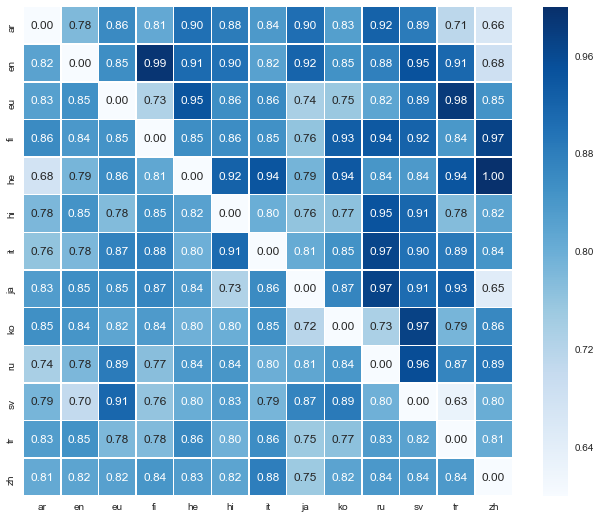

In [15]:
mask = np.triu(np.ones_like(d_emb, dtype=np.bool))
d_emb[mask] = d_e2e[mask]

sns.set(style="white")
d = pd.DataFrame(data=d_emb,
                 columns=sorted(in_language_embedding.keys()), index=sorted(in_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
    
sns.heatmap(d, vmax=1., vmin=0.6, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')

plt.savefig('cosine-heats-e2e.pdf', bbox_inches='tight', dpi=300)
plt.show()

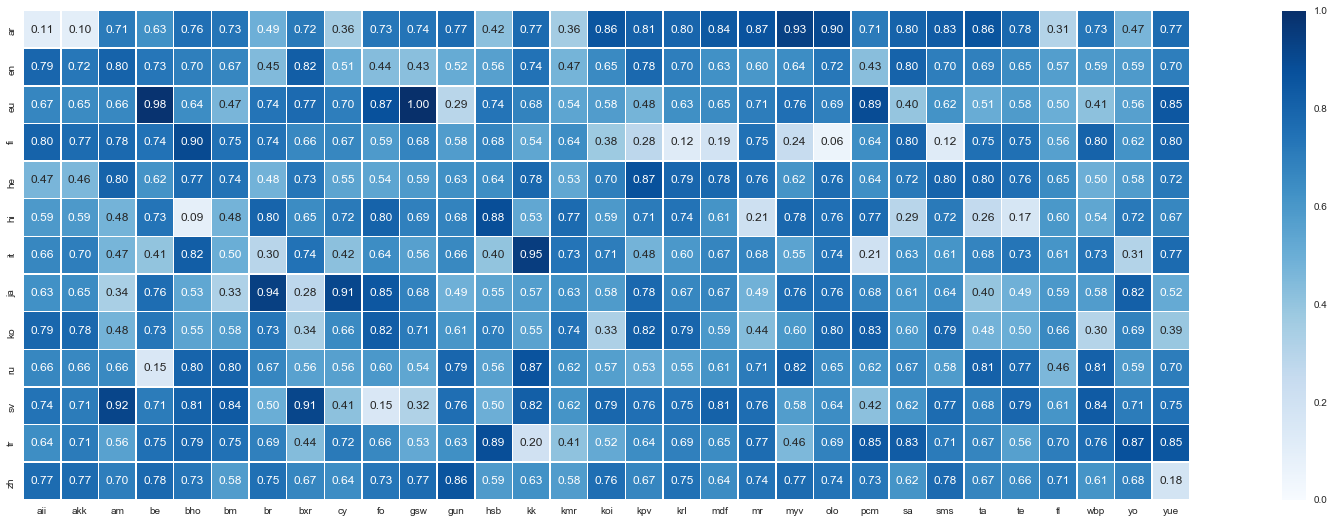

In [19]:
sns.set(style="white")
d = pd.DataFrame(data=lr_d_emb,
                 index=sorted(in_language_embedding.keys()), columns=sorted(oov_language_embedding.keys()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(33, 9))
    
sns.heatmap(d, vmax=1, vmin=0, 
            square=True, annot=True, linewidth = 0.5, cmap='Blues', fmt='0.2f')



plt.savefig('cosine-heats-lr-emb.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(languages, embeddings, language_codes, fig_name):
    "Creates and TSNE model and plots it"
    labels = languages
    tokens = embeddings
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    colorgroup = 13*['r'] + 31*['b']
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], c=colorgroup[i], label=language_codes[i], s=60)
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=22)
    ax = plt.subplot(111)
    box = ax.get_position()
    legend_x = 1.01
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y), fontsize='13')
    plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    plt.show()
    return new_values

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


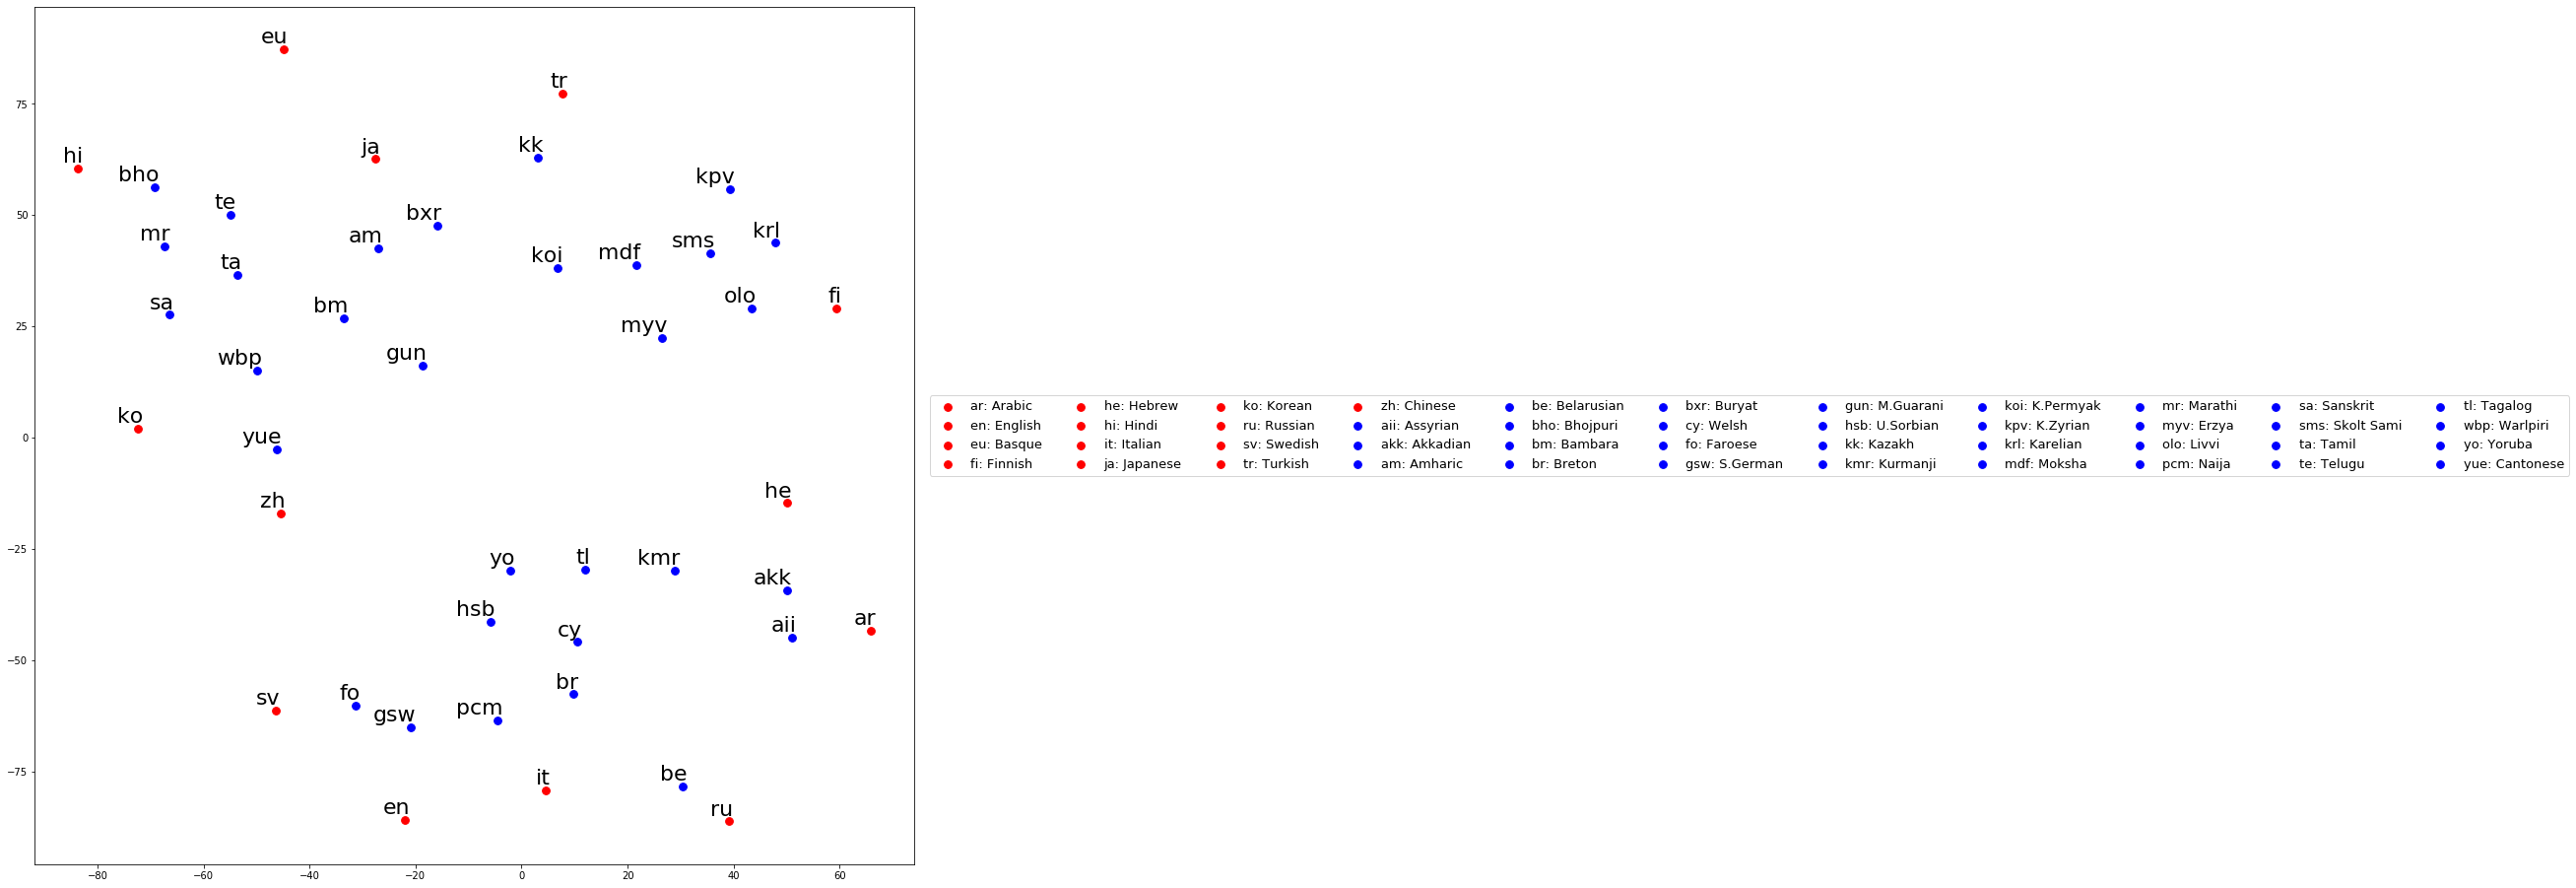

In [25]:
language_emb_2d = tsne_plot(languages, embeddings, lang_codes, 'language_embeddings.png')

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


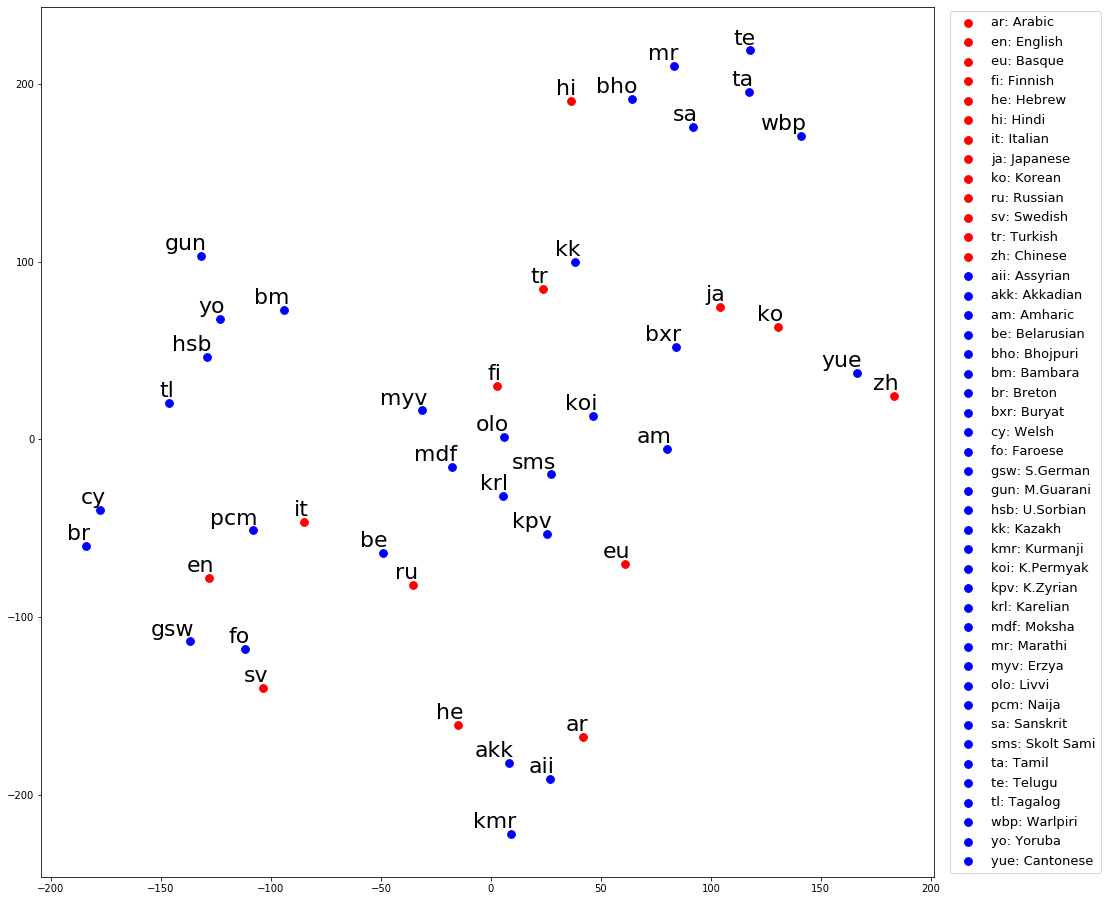

In [30]:
language_feat_2d = tsne_plot(languages, features, lang_codes, 'language_features.png')

/Users/ahmetustun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


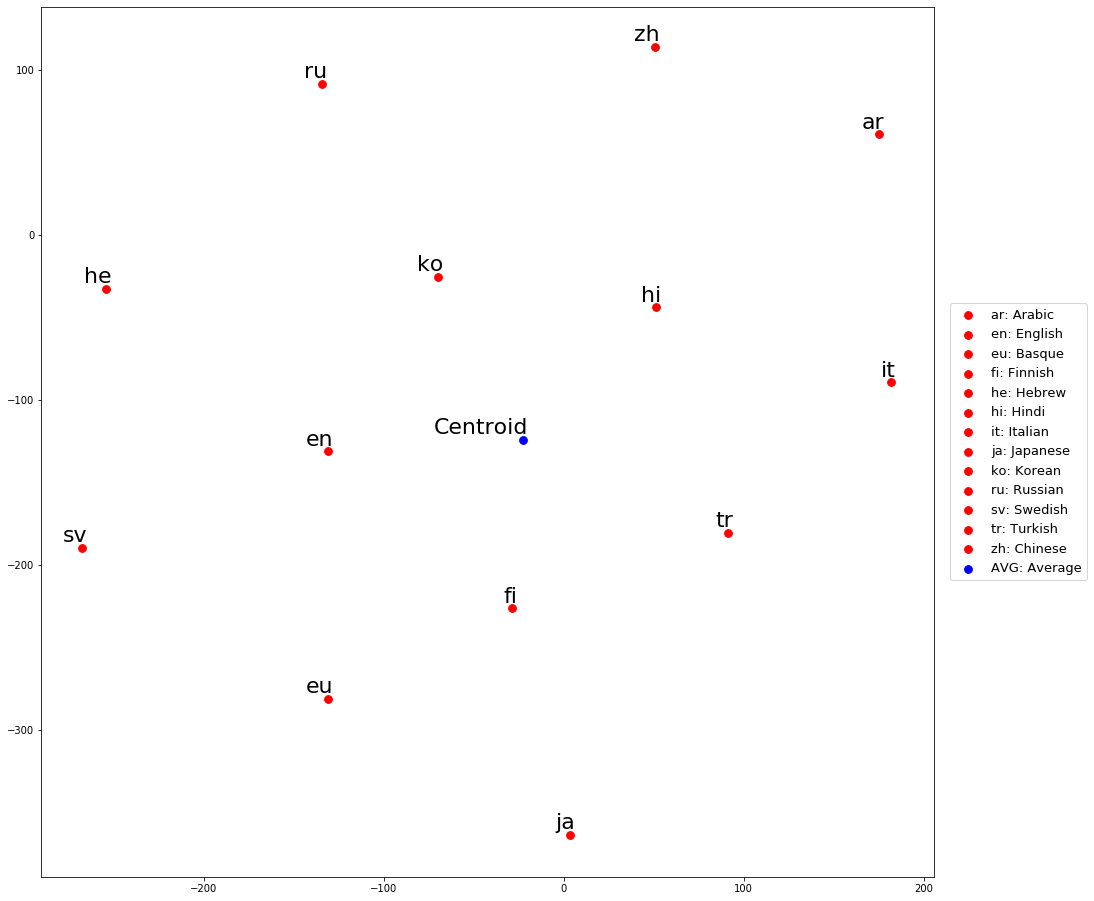

In [12]:
e2e_language_embedding = {lang: language_emb(torch.tensor([in_lang_list.index(lang)])) for lang in in_lang_list}
e2e_avg_embedding = {'AVG': language_emb(torch.tensor([1001]))}

languages_e2e = list(e2e_language_embedding.keys()) + ['Centroid']
embeddings_e2e = [emb.detach().numpy() for emb in e2e_language_embedding.values()] + [emb.detach().numpy() for emb in e2e_avg_embedding.values()]

language_e2e_2d = tsne_plot(languages_e2e, embeddings_e2e, lang_codes[:13]+['AVG: Average'], 'language_e2e.png')

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(language_emb_2d, 'single')

labelList = languages

plt.figure(figsize=(16, 8))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig('language_clusters.png', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(language_feat_2d, 'single')

labelList = languages

plt.figure(figsize=(16, 8))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.savefig('language_clusters_feat.png', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.nonlinear_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE']

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_all.png', bbox_inches='tight')

In [36]:
projection_weights = language_mlp.nonlinear_project.weight.data
norm_weights = torch.norm(projection_weights, dim=0, keepdim=True).numpy()
a = norm_weights.squeeze()

x=a
normalized = (x-min(x))/(max(x)-min(x))
normalized

means = [np.mean(a[:102]), np.mean(a[103:130]), np.mean(a[131:])]
std = [np.std(a[:102]), np.std(a[103:130]), np.std(a[131:])]
means

[0.5488218, 0.5439909, 0.54592335]

In [ ]:
most_weighted_features = [feature_codes[i] for i in a]
m_weights = np.sort(weights.detach().numpy())
m_weights = m_weights.squeeze()[-10:]
#print(most_weighted_features)
#print(m_weights)
most_weighted_features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.nonlinear_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,:103]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][:103]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_syntax.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.down_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,104:132]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][104:132]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_phonology.png', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

down_projection_weights = language_mlp.down_project.weight.data
weights = down_projection_weights.abs().sum(dim=0).view(1,-1)[:,133:]

features = l2v.get_features("eng", config.language_features, header=True)
feature_codes = features['CODE'][133:]

plt.subplots(figsize=(80, 3))
sns.heatmap(weights.detach().numpy(), yticklabels=False, xticklabels=feature_codes, cmap='Greys')
plt.xlabel("Language embeddings dimensions")
plt.savefig('heatmap_weights_inventory.png', bbox_inches='tight')